# Compute Zonal and Meridional SST gradients in CMIP6 historical runs for one ensemble one model

In [1]:
%matplotlib inline

import xarray as xr
import intake
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import util

In [2]:
def get_zm_gradient_anom(sst,ave_yr):
  # ave_yr: specify the number of yrs for running average 
  
   # get regional mean here
    WP_mean = util.simple_spatial_average(sst, lat_bounds=[-10, 10], lon_bounds=[120, 180])
    EP_mean = util.simple_spatial_average(sst, lat_bounds=[-10, 10], lon_bounds=[220, 280])
    trop_mean = 1/2*(WP_mean + EP_mean)
    extro_mean = util.simple_spatial_average(sst, lat_bounds=[-60, -40], lon_bounds=[120, 280])
   
   # define gradient
    Tg_z = WP_mean - EP_mean
    Tg_m = trop_mean - extro_mean

   # running average
    Tg_z = Tg_z.rolling(time=12*ave_yr).mean()
    Tg_m = Tg_z.rolling(time=12*ave_yr).mean()
    
    # get anomaly w.r.t
    Tg_z_anom = Tg_z - Tg_z.mean()
    Tg_m_anom = Tg_m - Tg_m.mean()

    return Tg_z_anom, Tg_m_anom

### Get info for all models available in NCAR glade, as a reference

In [3]:
if util.is_ncar_host():
    col = intake.open_esm_datastore("../catalogs/glade-cmip6.json")
else:
    col = intake.open_esm_datastore("../catalogs/pangeo-cmip6.json")
col

glade-cmip6-ESM Collection with 1115856 entries:
	> 17 activity_id(s)

	> 24 institution_id(s)

	> 48 source_id(s)

	> 82 experiment_id(s)

	> 163 member_id(s)

	> 35 table_id(s)

	> 1029 variable_id(s)

	> 12 grid_label(s)

	> 59 dcpp_init_year(s)

	> 251 version(s)

	> 7799 time_range(s)

	> 1115856 path(s)

In [4]:
# print out the names of all experiments/models/tables
import pprint 
uni_dict = col.unique(['source_id', 'experiment_id', 'table_id'])
pprint.pprint(uni_dict, compact=True)

{'experiment_id': {'count': 82,
                   'values': ['ssp370', 'histSST-piNTCF', 'histSST',
                              'histSST-1950HC', 'hist-1950HC', 'hist-piNTCF',
                              'piClim-NTCF', 'ssp370SST-lowNTCF',
                              'ssp370-lowNTCF', 'ssp370SST', '1pctCO2-bgc',
                              'hist-bgc', 'esm-ssp585', '1pctCO2-cdr',
                              'amip-future4K', 'amip-m4K', 'a4SST', 'aqua-p4K',
                              'piSST', 'amip-4xCO2', 'a4SSTice', 'amip-p4K',
                              'aqua-control', 'aqua-4xCO2', 'abrupt-4xCO2',
                              'historical', 'piControl', 'amip', '1pctCO2',
                              'esm-hist', 'esm-piControl', 'ssp245', 'ssp585',
                              'ssp126', 'hist-GHG', 'hist-aer', 'hist-nat',
                              'dcppA-hindcast', 'dcppC-hindcast-noPinatubo',
                              'dcppC-hindcast-noElChichon', 'dcppA-

## Pick out models that have target variables 
- ts: surface temperature (Amon)
- sftlf: land area fraction (fx)

In [5]:
cat_fx = col.search(experiment_id='historical', variable_id=['sftlf'],  table_id = 'fx', grid_label='gn')
model_lsmask = cat_fx.df.source_id.unique()

cat_fx = col.search(experiment_id='historical', variable_id=['ts'],  table_id = 'Amon', grid_label='gn')
model_ts = cat_fx.df.source_id.unique()

models = list(set(model_lsmask).intersection(model_ts))   ## Find the models that have both ts and sftlf. 

In [6]:
models

['NorESM2-LM',
 'MIROC-ES2L',
 'MIROC6',
 'MRI-ESM2-0',
 'CanESM5',
 'SAM0-UNICON',
 'CESM2',
 'CESM2-WACCM']

## read historical ts from one model one ensemble 

In [7]:
## read land-sea mask
cat = col.search(experiment_id='historical', variable_id=['sftlf'],  table_id=['fx'], source_id=models[1], grid_label='gn')
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': True}, 
                                cdf_kwargs={'chunks': {}, 'decode_times': True})
keys = list(dset_dict.keys())
lsmask = dset_dict[keys[0]]


xarray will load netCDF datasets with dask using a single chunk for all arrays.
For effective chunking, please provide chunks in cdf_kwargs.
For example: cdf_kwargs={'chunks': {'time': 36}}

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)


In [8]:
## read surface temperature
cat = col.search(experiment_id='historical', variable_id=['ts'],  table_id=['Amon'], source_id=models[1], grid_label='gn')
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': True}, 
                                cdf_kwargs={'chunks': {}, 'decode_times': True})
keys = list(dset_dict.keys())
ts = dset_dict[keys[0]]


xarray will load netCDF datasets with dask using a single chunk for all arrays.
For effective chunking, please provide chunks in cdf_kwargs.
For example: cdf_kwargs={'chunks': {'time': 36}}

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)


In [9]:
# if da_sst (Dataset) has member_id > 1 (multi ensembles)
#  --- get ensemble-mean here
da_sst = ts.ts.mean(dim = 'member_id')

In [10]:
# take out ocean TS as SST, and convert to deg C
sst = da_sst.where(lsmask.sftlf[0,:,:]== 0)-273.15
# make sure the land-sea mask works
#sst.isel(time=0).plot()

### Ready to move to regional averages

In [11]:
# plot to see the box selected

#sst.isel(time = 0).sel(lat=slice(-20, 20),lon=slice(100, 120)).plot()
lat = sst.lat
lon = sst.lon

# fig, axes = plt.subplots(ncols=3,figsize= (14,5))
# sst.isel(time = 0).where((lat>=-10) & (lat<=10) & (lon>=120) & (lon<=180)).plot(ax=axes[0])
# sst.isel(time = 0).where((lat>=-10) & (lat<=10) & (lon>=220) & (lon<=280)).plot(ax=axes[1])
# sst.isel(time = 0).where((lat>=-60) & (lat<=-40) & (lon>=120) & (lon<=280)).plot(ax=axes[2])

# one axis with three plots
# sst.isel(time = 0).where((lat>=-10) & (lat<=10) & (lon>=120) & (lon<=180)).plot()
# sst.isel(time = 0).where((lat>=-10) & (lat<=10) & (lon>=220) & (lon<=280)).plot()
# sst.isel(time = 0).where((lat>=-60) & (lat<=-40) & (lon>=120) & (lon<=280)).plot()

wp = (lat>=-10) & (lat<=10) & (lon>=120) & (lon<=180)
ep = (lat>=-10) & (lat<=10) & (lon>=220) & (lon<=280)
so = (lat>=-60) & (lat<=-40) & (lon>=120) & (lon<=280)

#sst.isel(time = 0).where(wp | ep | so).plot()

In [12]:
# get regional mean here
WP_mean = util.simple_spatial_average(sst, lat_bounds=[-10, 10], lon_bounds=[120, 180])
EP_mean = util.simple_spatial_average(sst, lat_bounds=[-10, 10], lon_bounds=[220, 280])
trop_mean = 1/2*(WP_mean + EP_mean)
extro_mean = util.simple_spatial_average(sst, lat_bounds=[-60, -40], lon_bounds=[120, 280])

# define gradient
Tg_z = WP_mean - EP_mean
Tg_m = trop_mean - extro_mean

# running average
Tg_z = Tg_z.rolling(time=12*5).mean()
Tg_m = Tg_m.rolling(time=12*5).mean()

# get anomaly w.r.t
Tg_z_anom = Tg_z - Tg_z.mean()
Tg_m_anom = Tg_m - Tg_m.mean()

In [13]:
#Tg_z_anom,Tg_m_anom = get_zm_gradient_anom(sst,5)

/ncar/usr/jupyterhub/envs/cmip6-201910/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


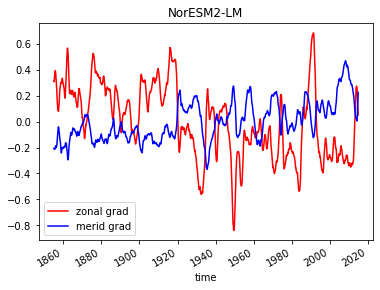

In [14]:
Tg_z_anom.plot(color='r',label='zonal grad')
Tg_m_anom.plot(color='b', label='merid grad')

plt.legend()
plt.title(models[0])
plt.savefig(models[0]+'.eps',format='eps')